In [1]:
import json
import numpy as np
import scipy.optimize as opt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
plt.rcParams['font.family'] = ['SimHei', 'Times New Roman']

In [2]:
class const:
    # 数据文件名相关
    label_ch_list = ['房颤', '动脉粥样硬化', '心梗', '脑梗']
    label_en_list = ['AF', 'AS', 'MI', 'CI']
    confidence_score_f = 'std'
    # 置信得分数据、预测评估源数据
    confidence_score_dict = r'..\..\PycharmProject-202412-集成学习\绘图数据【保留】\%s%s-confidence-score-dict-func=%s.json'
    do_write_predict_information_json_path = r'..\..\PycharmProject-202412-集成学习\绘图数据【保留】\%s%s-predict-information-dict-func=%s.json'
    # 函数拟合参数
    density = 200
    popt = {'AF': [], 'AS': [], 'MI': [], 'CI': []}

#### 拟合决策边界、保存拟合阈值曲线参数、绘制决策边界

In [8]:
def fit_func(x, a, b, c):  # 变量一定要放在第一个位置
    return a * x ** 2 + b * x + c
def curve_fit_boundary(label_en, confidence_score_dict, boundary_x_coordinate):
    pred_pro_weighted_sum = confidence_score_dict["true"]["pred_pro_weighted_sum"] + confidence_score_dict["false"]["pred_pro_weighted_sum"]  # 风险概率
    pred_pro_confidence = confidence_score_dict["true"]["pred_pro_confidence"] + confidence_score_dict["false"]["pred_pro_confidence"]  # 置信得分
    const.popt[label_en], pcov = opt.curve_fit(fit_func, pred_pro_weighted_sum, pred_pro_confidence)  # p0 = 1是因为只有a一参数
    boundary_y_coordinate_fit = fit_func(boundary_x_coordinate, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2])
    return boundary_y_coordinate_fit  # popt[0],popt[1],popt[2]分别代表参数a b c
def draw_boundary(confidence_score_dict, boundary_x_coordinate, boundary_y_coordinate_fit):  # 用离散点模拟绘制决策边界
    fig_3 = plt.figure(figsize=(16, 8))
    ax1=fig_3.add_subplot(111)
    plt.scatter(confidence_score_dict["false"]["pred_pro_weighted_sum"], confidence_score_dict["false"]["pred_pro_confidence"], label='错误分类', c='r', s=1)
    plt.scatter(confidence_score_dict["true"]["pred_pro_weighted_sum"], confidence_score_dict["true"]["pred_pro_confidence"], label='正确分类', c='k', s=1)
    plt.plot(boundary_x_coordinate, boundary_y_coordinate_fit, label='拟合阈值曲线', c='b', linewidth=3)
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.rcParams.update({'font.size': 32})
    plt.xlabel('风险概率')
    plt.ylabel('置信得分')
    plt.title('')
    ax1.set_xlim([-0.02, 1.02])
    # ax1.set_ylim([0.75, 1.02])
    ax1.spines['bottom'].set_linewidth(3)#设置底部坐标轴的粗细
    ax1.spines['left'].set_linewidth(3)#设置左边坐标轴的粗细
    ax1.spines['right'].set_linewidth(3)#设置右边坐标轴的粗细
    ax1.spines['top'].set_linewidth(3)#设置上部坐标轴的粗细
    plt.show()

#### 计数标签和计算评估值

In [4]:
def prepare_predict_information(label_en, label_ch):
    now_json_path_file_name = const.do_write_predict_information_json_path % (label_en, label_ch, const.confidence_score_f)
    predict_information_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))
    pred_pro_weighted_sum = np.array(predict_information_dict["pred_pro_weighted_sum"])
    pred_pro_confidence_score = np.array(predict_information_dict["pred_pro_confidence_score"])
    test_data_label_arr = np.array(predict_information_dict["test_data_label_arr"]).astype(int)  # 问题：JSON不能保存np.int，所以用float代替；此处转化回来
    pred_label_arr = np.array(predict_information_dict["pred_label_arr"]).astype(int)
    return pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr
def prepare_predict_information_dict(label_en, pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr):
    judge_y = pred_pro_confidence_score - fit_func(pred_pro_weighted_sum, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2])
    above_fit_func_index = np.where(judge_y >= 0)[0]  # 当popt的保留小数位数较短时，up_data_index/down_data_index内元素的个数将产生个位数的偏差
    below_fit_func_index = np.where(judge_y < 0)[0]
    above_fit_func_predict_information = {
        "pred_pro_weighted_sum": pred_pro_weighted_sum[above_fit_func_index],
        "test_data_label_arr":   test_data_label_arr[above_fit_func_index],
        "pred_label_arr":        pred_label_arr[above_fit_func_index]
    }
    below_fit_func_predict_information = {
        "pred_pro_weighted_sum": pred_pro_weighted_sum[below_fit_func_index],
        "test_data_label_arr":   test_data_label_arr[below_fit_func_index],
        "pred_label_arr":        pred_label_arr[below_fit_func_index]
    }
    return above_fit_func_predict_information, below_fit_func_predict_information
def calc_accuracy(tp, tn, amount_sum):
    return (tp + tn) / amount_sum
def calc_ppv(tp, fp):
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)
def calc_tpr(tp, fn):
    return tp / (tp + fn)
def calc_f1(tp, fn, fp):
    return 2 * tp / (2 * tp + fn + fp)  # 2*ppv*tpr/(ppv+tpr)
def count_label_arr_and_calc_assessed_values(predict_information_dict):
    predict_positive_label_index = np.where(predict_information_dict["pred_label_arr"] == 1)[0]
    predict_negative_label_index = np.where(predict_information_dict["pred_label_arr"] == 0)[0]
    test_data_positive_label_index = np.where(predict_information_dict["test_data_label_arr"] == 1)[0]
    test_data_negative_label_index = np.where(predict_information_dict["test_data_label_arr"] == 0)[0]
    tp_index = list(set(predict_positive_label_index) & set(test_data_positive_label_index))  # 取交集
    fn_index = list(set(predict_negative_label_index) & set(test_data_positive_label_index))
    fp_index = list(set(predict_positive_label_index) & set(test_data_negative_label_index))
    tn_index = list(set(predict_negative_label_index) & set(test_data_negative_label_index))
    tp_num = len(tp_index)  # 正类标记，被预测成正类的个数
    fn_num = len(fn_index)  # 正类标记，被预测成负类的个数
    fp_num = len(fp_index)  # 负类标记，被预测成正类的个数
    tn_num = len(tn_index)  # 负类标记，被预测成负类的个数
    amount_sum = tp_num + fn_num + fp_num + tn_num  # 总数
    false_positive_rate, true_positive_rate, thresholds_list = \
        roc_curve(predict_information_dict["test_data_label_arr"], predict_information_dict["pred_pro_weighted_sum"], pos_label=1)
    calc_assessed_values = {
        "acc":    calc_accuracy(tp_num, tn_num, amount_sum),
        "ppv":    calc_ppv(tp_num, fp_num),
        "tpr":    calc_tpr(tp_num, fn_num),
        "f1":     calc_f1(tp_num, fn_num, fp_num),
        "au_roc": auc(false_positive_rate, true_positive_rate),
        "tp_num": tp_num, "fn_num": fn_num, "fp_num": fp_num, "tn_num": tn_num
    }
    return calc_assessed_values
def print_assessed_values(label_en, label_ch):
    float_assessed_values_name_list = ["ACC", "PPV", "TPR", "F1", "AUC"]
    float_assessed_values_name_lowercase_list = ["acc", "ppv", "tpr", "f1", "au_roc"]
    int_assessed_values_name_list = ["TP", "FN", "FP", "TN"]
    int_assessed_values_name_lowercase_list = ["tp_num", "fn_num", "fp_num", "tn_num"]
    # 导入风险概率、置信得分、标记空间、预测结果
    pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr = prepare_predict_information(label_en, label_ch)
    # 区分高置信区间、低置信区间的风险概率、置信得分、标记空间、预测结果
    above_fit_func_predict_information, below_fit_func_predict_information =\
        prepare_predict_information_dict(label_en, pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr)
    # 评估高置信区间的预测效果
    calc_assessed_values_above_fit_func = count_label_arr_and_calc_assessed_values(above_fit_func_predict_information)
    # 评估低置信区间的预测效果
    calc_assessed_values_below_fit_func = count_label_arr_and_calc_assessed_values(below_fit_func_predict_information)
    # 输出拟合阈值曲线
    print('%s拟合阈值曲线：y = %.3f x^2 + %.3f x + %.3f\n' % (label_ch, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2]))
    # 输出评估
    print("%s\n\t高置信区间\t低置信区间" % label_ch)
    for name, name_lowercase in zip(float_assessed_values_name_list, float_assessed_values_name_lowercase_list):
        print("%s\t%.3f\t\t%.3f" % (name, calc_assessed_values_above_fit_func[name_lowercase], calc_assessed_values_below_fit_func[name_lowercase]))
    for name, name_lowercase in zip(int_assessed_values_name_list, int_assessed_values_name_lowercase_list):
        print("%s\t%d\t\t%d" % (name, calc_assessed_values_above_fit_func[name_lowercase], calc_assessed_values_below_fit_func[name_lowercase]))

In [9]:
def do_work(label_en, label_ch):
    # 准备Logistic回归所需的样本空间、标记空间
    now_json_path_file_name = const.confidence_score_dict % (label_en, label_ch, const.confidence_score_f)
    confidence_score_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))
    # 拟合决策边界、保存拟合阈值曲线参数
    boundary_y_coordinate_fit = curve_fit_boundary(label_en, confidence_score_dict, boundary_x_coordinate := np.linspace(0, 1, const.density))
    # 绘制风险概率-置信得分图、绘制决策边界坐标点、绘制决策边界拟合阈值曲线
    draw_boundary(confidence_score_dict, boundary_x_coordinate, boundary_y_coordinate_fit)
    # 输出拟合阈值曲线、计数标签和计算评估值
    print_assessed_values(label_en, label_ch)

In [5]:
# label_en, label_ch = const.label_en_list[0],const.label_ch_list[0]
# confidence_score_dict = prepare_data(label_en, label_ch)
# boundary_y_coordinate_fit = curve_fit_boundary(label_en, confidence_score_dict, boundary_x_coordinate := np.linspace(0, 1, const.density))
# draw_boundary(confidence_score_dict, boundary_x_coordinate, boundary_y_coordinate_fit)
# print_assessed_values(label_en, label_ch)

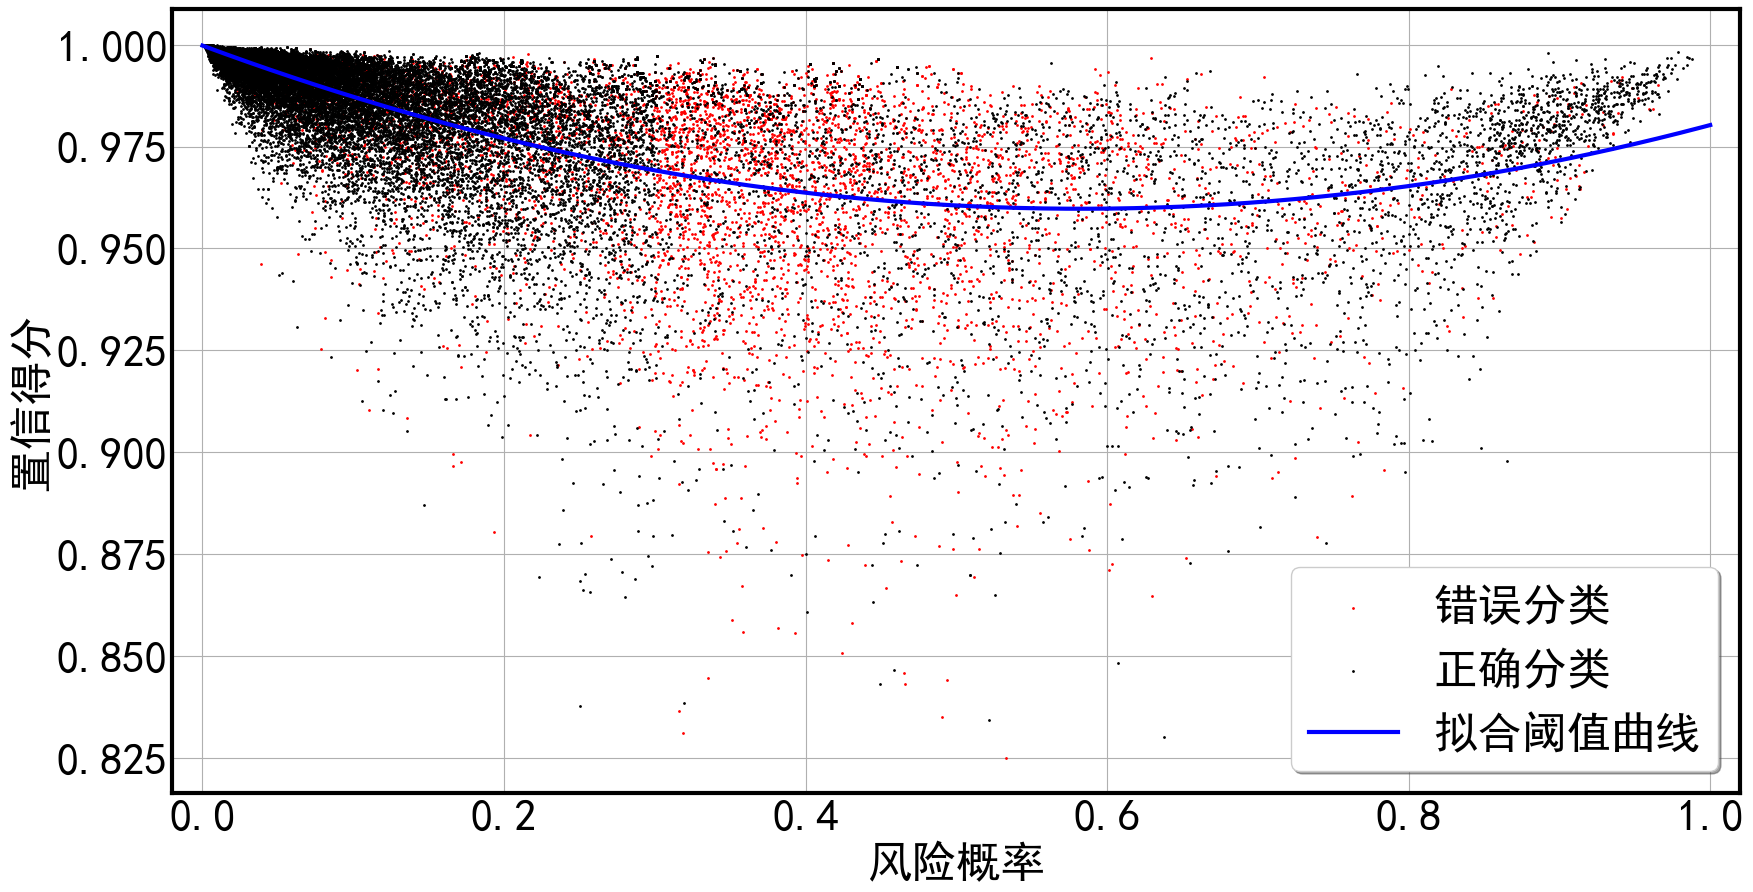

房颤拟合阈值曲线：y = 0.118 x^2 -0.137 x + 1.000

房颤
	高置信区间	低置信区间
ACC	0.875		0.845
PPV	0.514		0.492
TPR	0.624		0.619
F1	0.564		0.548
AUC	0.895		0.860
TP	2452		1510
FN	1480		928
FP	2317		1558
TN	24081		12034


In [10]:
do_work(const.label_en_list[0],const.label_ch_list[0])

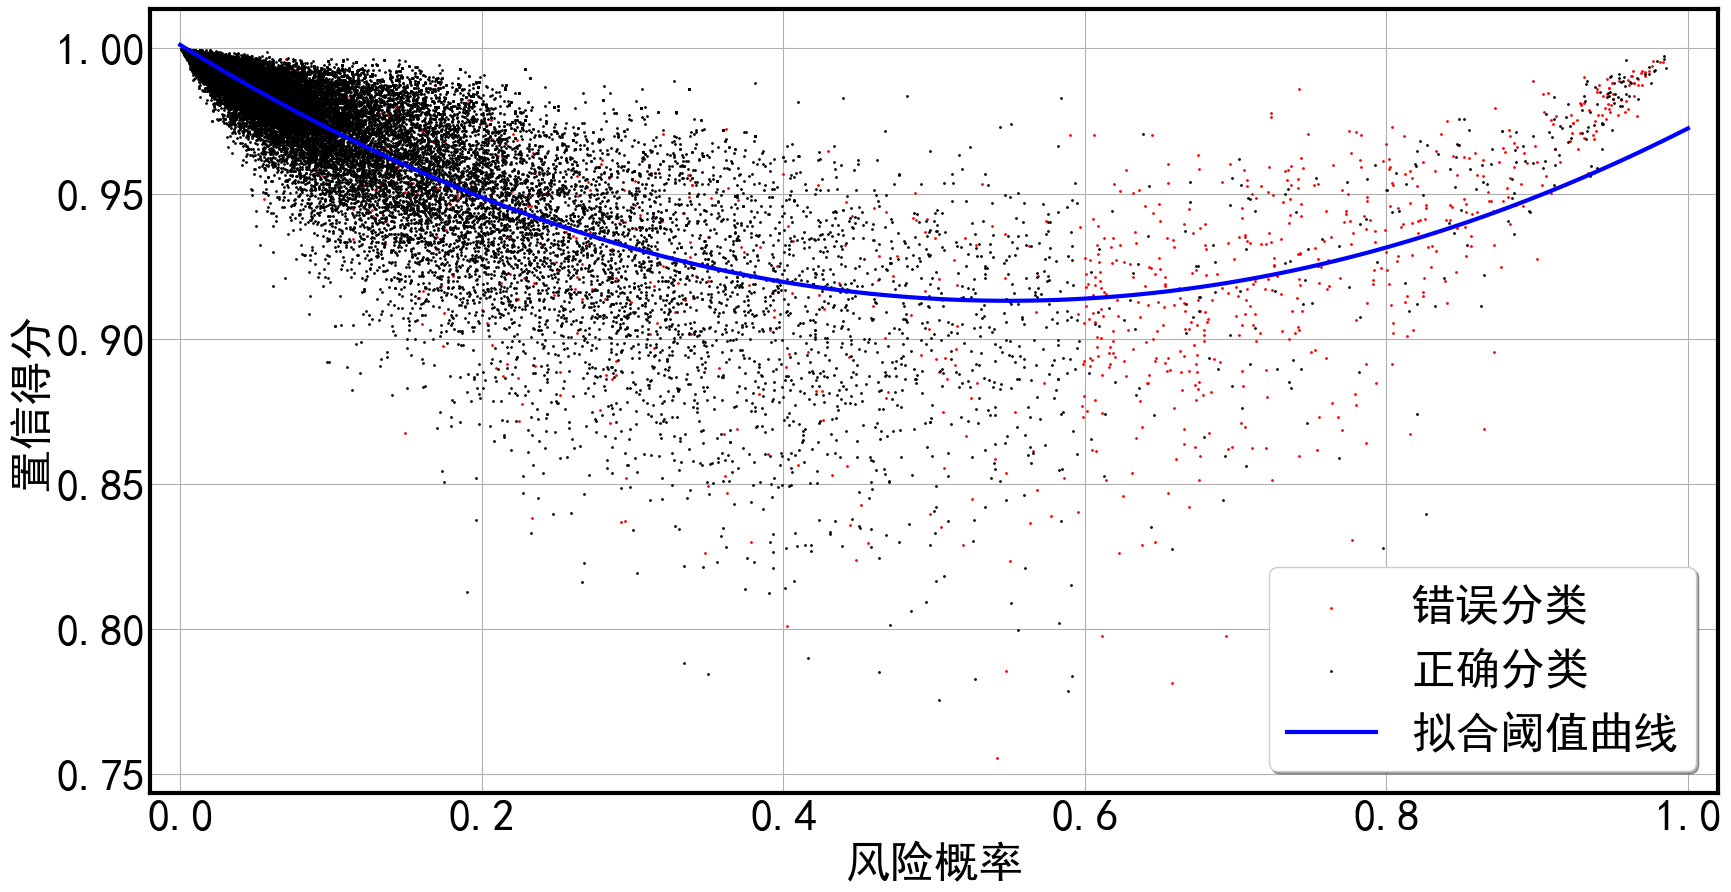

动脉粥样硬化拟合阈值曲线：y = 0.292 x^2 -0.321 x + 1.001

动脉粥样硬化
	高置信区间	低置信区间
ACC	0.969		0.983
PPV	0.336		0.239
TPR	0.328		0.227
F1	0.332		0.233
AUC	0.829		0.901
TP	155		70
FN	317		238
FP	306		223
TN	19228		25823


In [11]:
do_work(const.label_en_list[1],const.label_ch_list[1])

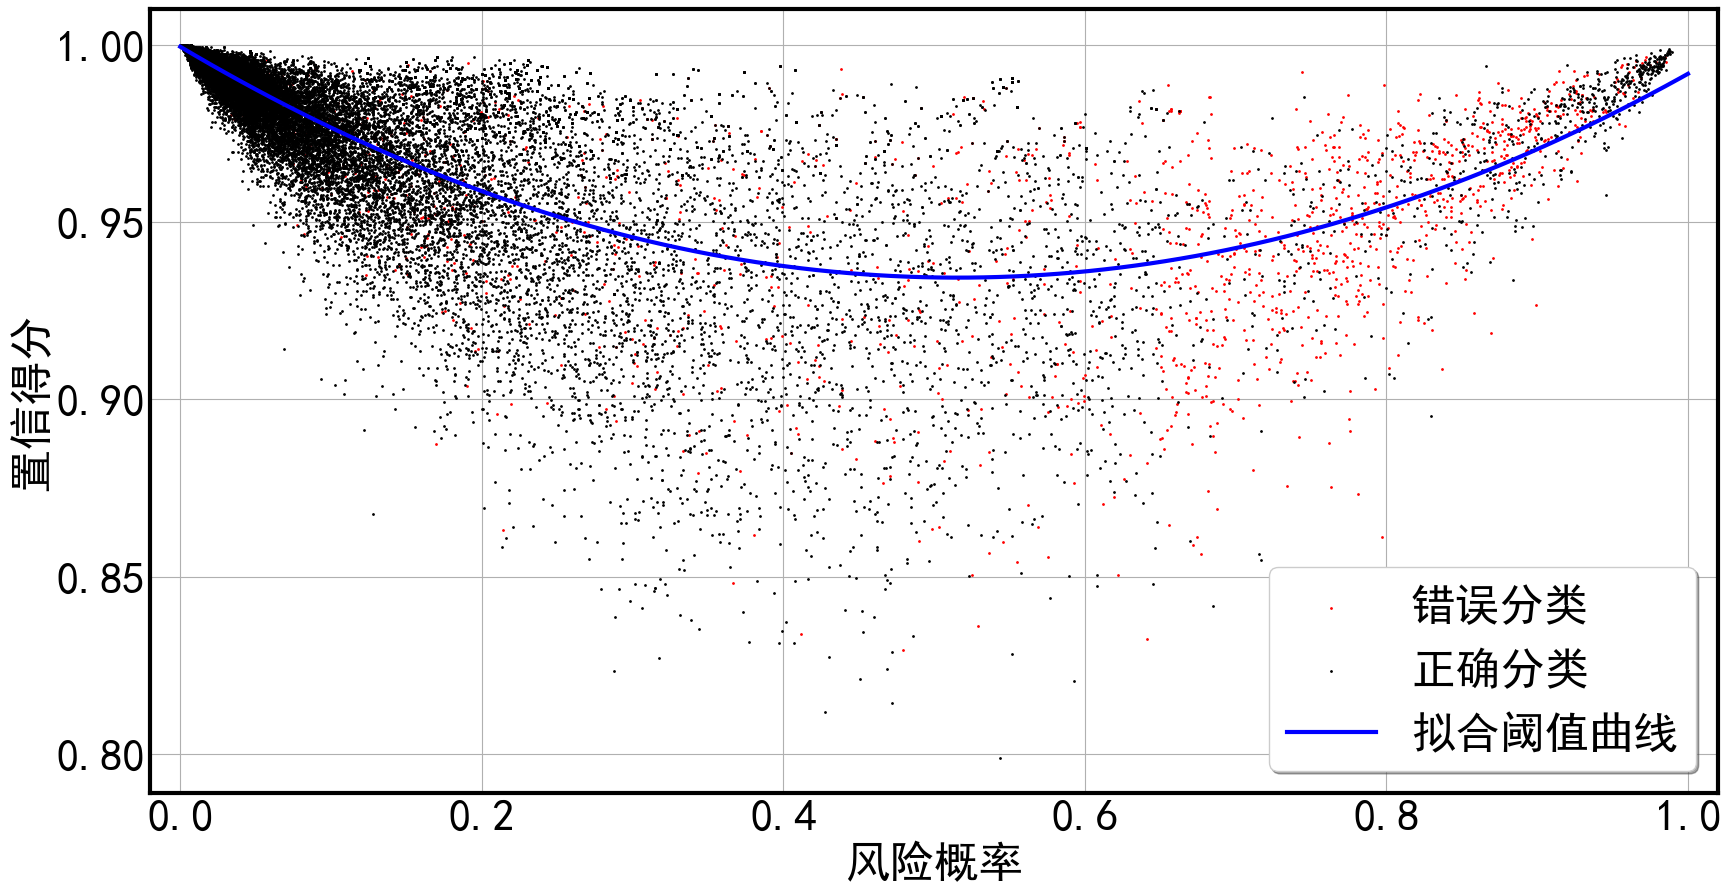

心梗拟合阈值曲线：y = 0.245 x^2 -0.252 x + 0.999

心梗
	高置信区间	低置信区间
ACC	0.971		0.953
PPV	0.521		0.344
TPR	0.531		0.358
F1	0.526		0.351
AUC	0.943		0.881
TP	476		212
FN	420		380
FP	437		405
TN	28208		15822


In [12]:
do_work(const.label_en_list[2],const.label_ch_list[2])

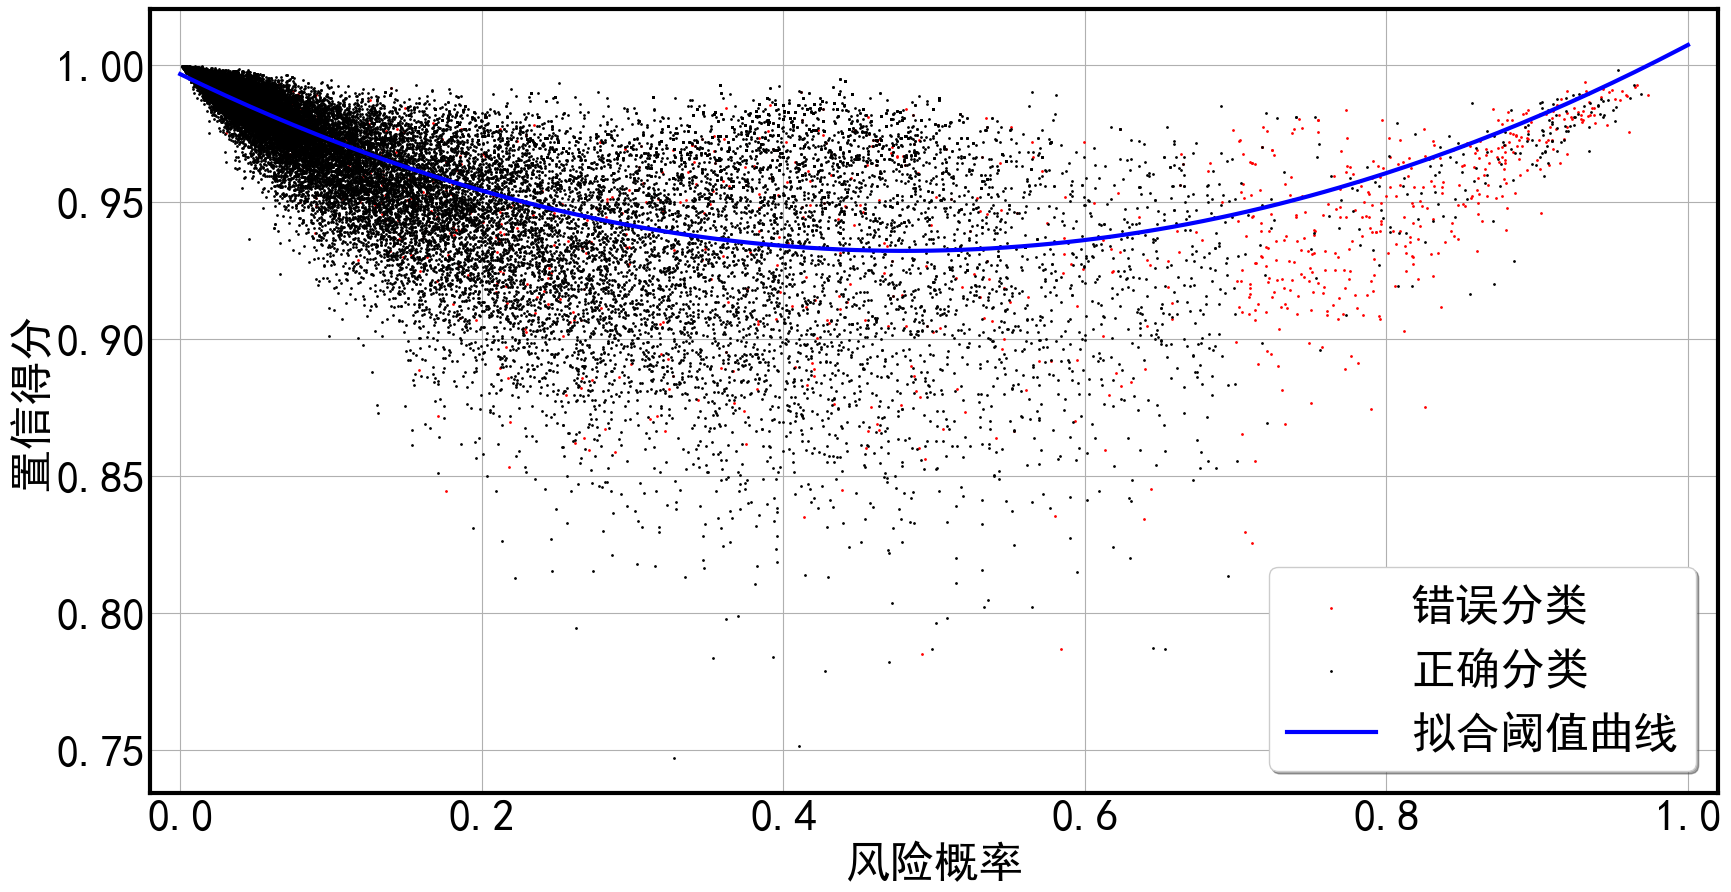

脑梗拟合阈值曲线：y = 0.279 x^2 -0.269 x + 0.997

脑梗
	高置信区间	低置信区间
ACC	0.986		0.963
PPV	0.359		0.306
TPR	0.107		0.304
F1	0.164		0.305
AUC	0.862		0.810
TP	42		136
FN	352		311
FP	75		309
TN	29024		16111


In [13]:
do_work(const.label_en_list[3],const.label_ch_list[3])